In [1]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")
import wrangle

import pandas as pd
pd.options.display.max_rows = 100

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures



>## Acquiring data through wrangle.py


In [2]:
df=wrangle.get_zillow_data()

>## Defining the dataset

In [3]:
#seeing what dataset looks like
wrangle.df_summary(df)

---Shape: (52319, 68)

---Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52319 entries, 0 to 52318
Data columns (total 68 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            52319 non-null  int64  
 1   parcelid                      52319 non-null  int64  
 2   airconditioningtypeid         13615 non-null  float64
 3   architecturalstyletypeid      70 non-null     float64
 4   basementsqft                  47 non-null     float64
 5   bathroomcnt                   52319 non-null  float64
 6   bedroomcnt                    52319 non-null  float64
 7   buildingclasstypeid           0 non-null      float64
 8   buildingqualitytypeid         33654 non-null  float64
 9   calculatedbathnbr             52184 non-null  float64
 10  decktypeid                    389 non-null    float64
 11  finishedfloor1squarefeet      4371 non-null   float64
 12  calculatedfinishedsquarefeet 

>## Handling nulls and missing values:

In [4]:
#setting up missing values function, to catch only the %%% of data that
#is already there, and not missing.

#checking nulls by columns of the percent of nulls found:

wrangle.nulls_by_columns(df).sort_values(by='percent', ascending=False)


,count,percent
buildingclassdesc,52319,1.000000
buildingclasstypeid,52319,1.000000
finishedsquarefeet15,52319,1.000000
finishedsquarefeet13,52319,1.000000
storytypeid,52272,0.999102
basementsqft,52272,0.999102
storydesc,52272,0.999102
yardbuildingsqft26,52256,0.998796
architecturalstyletypeid,52249,0.998662
architecturalstyledesc,52249,0.998662


In [5]:
#now let's look at nulls by rows:
wrangle.nulls_by_rows(df)

n_missing  percent_missing
23         0.338235               2
24         0.352941              12
25         0.367647              11
26         0.382353              30
27         0.397059             177
28         0.411765             390
29         0.426471            2527
30         0.441176            2199
31         0.455882            5989
32         0.470588            8885
33         0.485294           11967
34         0.500000           11157
35         0.514706            3469
36         0.529412            4138
37         0.544118            1020
38         0.558824             223
39         0.573529              29
40         0.588235              15
41         0.602941               6
42         0.617647               7
43         0.632353              10
44         0.647059              46
45         0.661765               6
46         0.676471               1
47         0.691176               1
48         0.705882               2
dtype: int64

### TAKE AWAYS:
- For missing values in columns, there is a big difference between regionneighborhood (60% missing) vs building quality type (38%), so I will will set my columns at 60%, since I do want to capture the regionneighborhood.
- Columns missing values I'll keep at 60% as it looks to be a good split on what is missing.

In [6]:
#using 60/60 first to see what dataset looks like:
print('Before dropping nulls, %d rows, %d cols' % df.shape)

#dropping the cols & rows that do not meet the 60/60 standard
df = wrangle.handle_missing_values(df, prop_required_column=.6, prop_required_row=.60)
print('After dropping nulls, %d rows, %d cols' % df.shape)

Before dropping nulls, 52319 rows, 68 cols
After dropping nulls, 52319 rows, 34 cols


In [7]:
#taking a look at what nulls are left
df.isnull().sum()

id                                  0
parcelid                            0
bathroomcnt                         0
bedroomcnt                          0
buildingqualitytypeid           18665
calculatedbathnbr                 135
calculatedfinishedsquarefeet       81
finishedsquarefeet12              246
fips                                0
fullbathcnt                       135
heatingorsystemtypeid           18470
latitude                            0
longitude                           0
lotsizesquarefeet                 366
propertycountylandusecode           0
propertylandusetypeid               0
propertyzoningdesc              18558
rawcensustractandblock              0
regionidcity                     1036
regionidcounty                      0
regionidzip                        26
roomcnt                             0
unitcnt                         18558
yearbuilt                         114
structuretaxvaluedollarcnt         82
taxvaluedollarcnt                   1
assessmentye

#### For my next null steps:
    - I'll drop all the larger null columns.
    - I'll drop all columns that reiterate information too.
    - I'll then decide what to do with leftover row nulls

In [8]:
#creating a function to remove unwanted columns (*may add/change later)

cols_to_remove = ['roomcnt','propertycountylandusecode','propertylandusedesc','propertyzoningdesc','buildingqualitytypeid','heatingorsystemtypeid','unitcnt','heatingorsystemdesc','calculatedbathnbr','id','finishedsquarefeet12','fullbathcnt','structuretaxvaluedollarcnt','landtaxvaluedollarcnt','taxamount','regionidcity','censustractandblock','transactiondate']
def remove_columns(df, cols_to_remove): 
    df = df.drop(columns=cols_to_remove)
    return df

df= remove_columns(df, cols_to_remove )
df.isnull().sum()

parcelid                          0
bathroomcnt                       0
bedroomcnt                        0
calculatedfinishedsquarefeet     81
fips                              0
latitude                          0
longitude                         0
lotsizesquarefeet               366
propertylandusetypeid             0
rawcensustractandblock            0
regionidcounty                    0
regionidzip                      26
yearbuilt                       114
taxvaluedollarcnt                 1
assessmentyear                    0
logerror                          0
dtype: int64

In [9]:
#considering how to handle each low count null...
df.lotsizesquarefeet.mean()

11323.453910265047

In [10]:
#looking at value_counts() for each leftover nulls
df.lotsizesquarefeet.value_counts()

6000.0     873
5000.0     413
7200.0     306
7000.0     285
6500.0     272
          ... 
18024.0      1
20673.0      1
4775.0       1
9367.0       1
47405.0      1
Name: lotsizesquarefeet, Length: 14292, dtype: int64

### TAKEAWAYS:

After thinking about what the nulls might be in these rows, I have decided to drop them as I think for the lotsize and calculatedsqft, these will be dropped anyways once I apply the outlier ranges.

In [11]:
#dropping the rest of the nulls as losing that many rows out of 52,000 shouldn't affect my data by much
def drop_r_nulls(df):
    df = df.dropna()
    return df

df = drop_r_nulls(df)
df.isnull().sum()

parcelid                        0
bathroomcnt                     0
bedroomcnt                      0
calculatedfinishedsquarefeet    0
fips                            0
latitude                        0
longitude                       0
lotsizesquarefeet               0
propertylandusetypeid           0
rawcensustractandblock          0
regionidcounty                  0
regionidzip                     0
yearbuilt                       0
taxvaluedollarcnt               0
assessmentyear                  0
logerror                        0
dtype: int64

In [12]:
df

,parcelid,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,propertylandusetypeid,rawcensustractandblock,regionidcounty,regionidzip,yearbuilt,taxvaluedollarcnt,assessmentyear,logerror
0,14297519,3.5,4.0,3100.0,6059.0,33634931.0,-117869207.0,4506.0,261.0,6.059063e+07,1286.0,96978.0,1998.0,1023282.0,2016.0,0.025595
1,17052889,1.0,2.0,1465.0,6111.0,34449266.0,-119281531.0,12647.0,261.0,6.111001e+07,2061.0,97099.0,1967.0,464000.0,2016.0,0.055619
2,14186244,2.0,3.0,1243.0,6059.0,33886168.0,-117823170.0,8432.0,261.0,6.059022e+07,1286.0,97078.0,1962.0,564778.0,2016.0,0.005383
3,12177905,3.0,4.0,2376.0,6037.0,34245180.0,-118240722.0,13038.0,261.0,6.037300e+07,3101.0,96330.0,1970.0,145143.0,2016.0,-0.103410
4,12095076,3.0,4.0,2962.0,6037.0,34145202.0,-118179824.0,63000.0,261.0,6.037461e+07,3101.0,96293.0,1950.0,773303.0,2016.0,-0.001011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52314,12412492,2.0,4.0,1633.0,6037.0,33870815.0,-118070858.0,4630.0,261.0,6.037555e+07,3101.0,96204.0,1962.0,346534.0,2016.0,0.001082
52315,11000655,2.0,2.0,1286.0,6037.0,34245368.0,-118282383.0,47405.0,261.0,6.037101e+07,3101.0,96284.0,1940.0,354621.0,2016.0,0.020615
52316,17239384,2.0,4.0,1612.0,6111.0,34300140.0,-118706327.0,12105.0,261.0,6.111008e+07,2061.0,97116.0,1964.0,67205.0,2016.0,0.013209
52317,12773139,1.0,3.0,1032.0,6037.0,34040895.0,-118038169.0,5074.0,261.0,6.037434e+07,3101.0,96480.0,1954.0,49546.0,2016.0,0.037129


_______________________________________________________________________________________________________

>## Looking at Dtypes:

In [13]:
df.dtypes

parcelid                          int64
bathroomcnt                     float64
bedroomcnt                      float64
calculatedfinishedsquarefeet    float64
fips                            float64
latitude                        float64
longitude                       float64
lotsizesquarefeet               float64
propertylandusetypeid           float64
rawcensustractandblock          float64
regionidcounty                  float64
regionidzip                     float64
yearbuilt                       float64
taxvaluedollarcnt               float64
assessmentyear                  float64
logerror                        float64
dtype: object

### Takeaways:
- I will leave these as floats.
- I will leave the object columns alone (and will one-hot-encode fips)

## Split the Data:

Using the Train, Validate, Test split function from my Regression project:
<br>- First, using 80/20 split between Train and Test
<br>- Then, using 70/30 split and stratifying on fips(county) for even mix of data between each county

In [14]:
def split_data(df):
    '''
    take in a DataFrame and return train, validate, and test DataFrames; stratify on species.
    return train, validate, test DataFrames.
    '''
    
    # splits df into train_validate and test using train_test_split() stratifying on species to get an even mix of each species
    train_validate, test = train_test_split(df, test_size=.2, random_state=123, stratify=df.fips)
    
    # splits train_validate into train and validate using train_test_split() stratifying on species to get an even mix of each species
    train, validate = train_test_split(train_validate, 
                                       test_size=.3, 
                                       random_state=123, 
                                       stratify=train_validate.fips)
    return train, validate, test


train, validate, test = wrangle.split_data(df)
train

,parcelid,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,propertylandusetypeid,rawcensustractandblock,regionidcounty,regionidzip,yearbuilt,taxvaluedollarcnt,assessmentyear,logerror
34222,11533536,1.0,2.0,864.0,6037.0,33986536.0,-118424309.0,5002.0,261.0,6.037275e+07,3101.0,96047.0,1950.0,787004.0,2016.0,0.063660
21551,11058331,2.0,3.0,1243.0,6037.0,34270033.0,-118492886.0,7795.0,261.0,6.037111e+07,3101.0,96370.0,1953.0,174930.0,2016.0,0.059323
39107,14003091,2.0,4.0,1157.0,6059.0,33794310.0,-117985512.0,7350.0,261.0,6.059088e+07,1286.0,97023.0,1954.0,274539.0,2016.0,0.184348
9029,14208016,2.0,3.0,1491.0,6059.0,33861905.0,-117769542.0,6000.0,261.0,6.059022e+07,1286.0,97027.0,1975.0,523394.0,2016.0,-0.004648
2982,10844442,2.0,4.0,1843.0,6037.0,34173761.0,-118454651.0,7202.0,261.0,6.037128e+07,3101.0,96420.0,1949.0,113758.0,2016.0,0.025679
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26973,12685721,2.0,3.0,1758.0,6037.0,33797494.0,-118367130.0,10192.0,261.0,6.037670e+07,3101.0,96121.0,1952.0,140998.0,2016.0,-0.171849
26978,11203451,2.0,3.0,1560.0,6037.0,34571891.0,-118081365.0,7062.0,261.0,6.037911e+07,3101.0,97328.0,1965.0,193000.0,2016.0,0.050356
6444,13060661,3.0,5.0,2204.0,6037.0,34031588.0,-117800357.0,7265.0,261.0,6.037403e+07,3101.0,96505.0,1965.0,447063.0,2016.0,0.027504
46771,11516057,6.0,5.0,5200.0,6037.0,33995370.0,-118369954.0,9118.0,261.0,6.037703e+07,3101.0,96037.0,1958.0,1125682.0,2016.0,0.100770


## Encoding the Data:
>#### I want to encode the fips column so that I can use it as a feature for comparing clusters to other features
-I will start with Los Angeles County as the main predictor for this column, as I already known from using this data that this is the largest county with the most dataset, but later add on encoding for each county, to maybe make into their own models.

In [15]:
#encode fips
def one_hot_encode(train):
    train['is_Los_Angeles'] = train.fips == 6037.0
    validate['is_Los_Angeles'] = validate.fips == 6037.0
    test['is_Los_Angeles'] = test.fips == 6037.0
    
    train['is_Ventura'] = train.fips == 6111.0
    validate['is_Ventura'] = validate.fips == 6111.0
    test['is_Ventura'] = test.fips == 6111.0
    
    train['is_Orange'] = train.fips == 6059.0
    validate['is_Orange'] = validate.fips == 6059.0
    test['is_Orange'] = test.fips == 6059.0
    
    return train

one_hot_encode(train)

#and then I need to turn this new column into an int:
train["is_Los_Angeles"] = train["is_Los_Angeles"].astype(int)
validate["is_Los_Angeles"] = validate["is_Los_Angeles"].astype(int)
test["is_Los_Angeles"] = test["is_Los_Angeles"].astype(int)

train['is_Ventura'] = train['is_Ventura'].astype(int)
validate['is_Ventura'] = validate['is_Ventura'].astype(int)
test['is_Ventura'] = test['is_Ventura'].astype(int)


train['is_Orange'] = train['is_Orange'].astype(int)
validate['is_Orange'] = validate['is_Orange'].astype(int)
test['is_Orange'] = test['is_Orange'].astype(int)

train

#this is all saved in the wrangle.py file!

,parcelid,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,propertylandusetypeid,rawcensustractandblock,regionidcounty,regionidzip,yearbuilt,taxvaluedollarcnt,assessmentyear,logerror,is_Los_Angeles,is_Ventura,is_Orange
34222,11533536,1.0,2.0,864.0,6037.0,33986536.0,-118424309.0,5002.0,261.0,6.037275e+07,3101.0,96047.0,1950.0,787004.0,2016.0,0.063660,1,0,0
21551,11058331,2.0,3.0,1243.0,6037.0,34270033.0,-118492886.0,7795.0,261.0,6.037111e+07,3101.0,96370.0,1953.0,174930.0,2016.0,0.059323,1,0,0
39107,14003091,2.0,4.0,1157.0,6059.0,33794310.0,-117985512.0,7350.0,261.0,6.059088e+07,1286.0,97023.0,1954.0,274539.0,2016.0,0.184348,0,0,1
9029,14208016,2.0,3.0,1491.0,6059.0,33861905.0,-117769542.0,6000.0,261.0,6.059022e+07,1286.0,97027.0,1975.0,523394.0,2016.0,-0.004648,0,0,1
2982,10844442,2.0,4.0,1843.0,6037.0,34173761.0,-118454651.0,7202.0,261.0,6.037128e+07,3101.0,96420.0,1949.0,113758.0,2016.0,0.025679,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26973,12685721,2.0,3.0,1758.0,6037.0,33797494.0,-118367130.0,10192.0,261.0,6.037670e+07,3101.0,96121.0,1952.0,140998.0,2016.0,-0.171849,1,0,0
26978,11203451,2.0,3.0,1560.0,6037.0,34571891.0,-118081365.0,7062.0,261.0,6.037911e+07,3101.0,97328.0,1965.0,193000.0,2016.0,0.050356,1,0,0
6444,13060661,3.0,5.0,2204.0,6037.0,34031588.0,-117800357.0,7265.0,261.0,6.037403e+07,3101.0,96505.0,1965.0,447063.0,2016.0,0.027504,1,0,0
46771,11516057,6.0,5.0,5200.0,6037.0,33995370.0,-118369954.0,9118.0,261.0,6.037703e+07,3101.0,96037.0,1958.0,1125682.0,2016.0,0.100770,1,0,0


## Data Distributions:
Looking at each feature and its distribution through histograms:

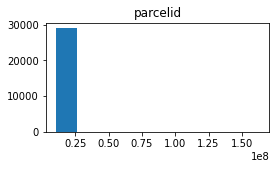

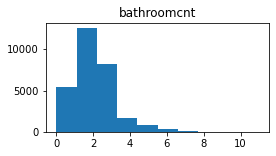

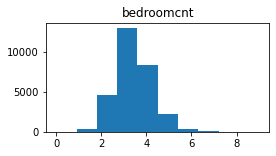

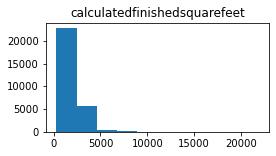

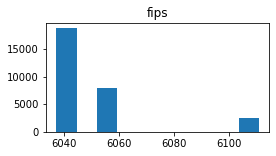

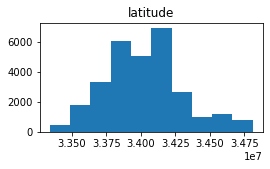

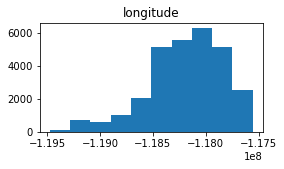

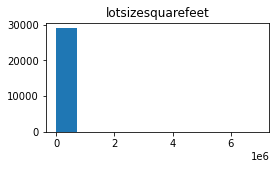

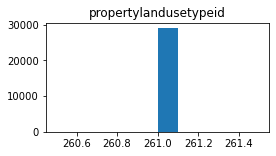

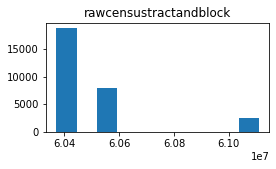

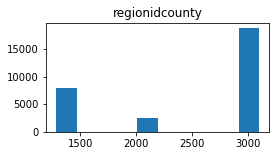

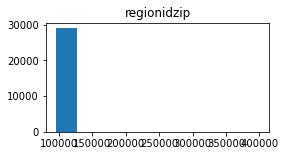

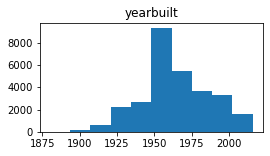

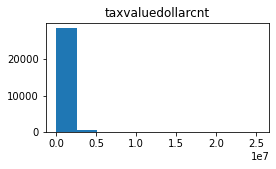

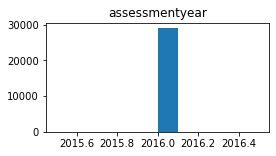

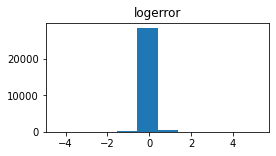

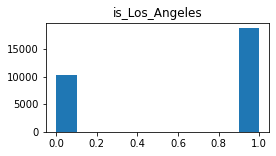

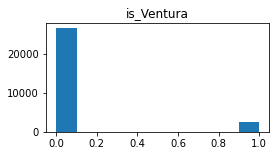

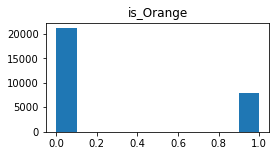

In [16]:
#create all the histograms:
for col in train.columns:
    plt.figure(figsize=(4,2))
    plt.hist(train[col])
    plt.title(col)
    plt.show()

### TAKEAWAYS:
- I'll add in some outlier ranges to help these distributions look at bit more 'normal'
- Some columns won't need to be changed (ie. latitude/longitude/zipcode/census/etc)

## Handling Outliers:

>I'll be using the ranges I set in my Regression project to handle outliers:

- Finished Squarefoot Range: 200sqft - 9_000sqft
- Bedroom Count range: 1-6bd
- Bathroom Count range:1-6bd
- Property Tax Value range: 45k - 2.5million

And adding new ranges of:

- Year built: 1950 - 2001
- Lot Sqft: 2,500 - 435,600 (10acres)...based on CA requirements for minimum and capturing more of Zillow's max clients

(array([  18.,  148.,  602., 2230., 2699., 9292., 5426., 3691., 3312.,
        1609.]),
 array([1880. , 1893.6, 1907.2, 1920.8, 1934.4, 1948. , 1961.6, 1975.2,
        1988.8, 2002.4, 2016. ]),
 <BarContainer object of 10 artists>)

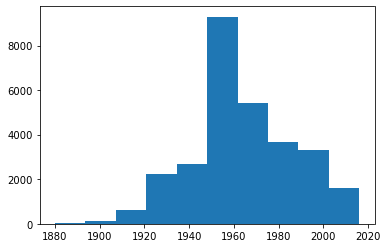

In [17]:
#upclose chart of years to look at the ranges
plt.hist(train.yearbuilt)

#I want to cut out the side 'tails' to really hon into this feature for some hypothesis testing

Creating the outlier ranges:

In [18]:
def handle_outliers(df):
    """Manually handle outliers that do not represent properties likely for the larger majority of buyers and zillow visitors"""
    #max/min of calculatedsqft
    df = df[df.calculatedfinishedsquarefeet <= 9_000]
    df = df[df.calculatedfinishedsquarefeet >= 200]
    #max/min of bedroomcnt
    df = df[df.bedroomcnt <= 6]
    df = df[df.bedroomcnt != 0]
    #max/min of bathroomcnt
    df = df[df.bathroomcnt <= 6]
    df = df[df.bathroomcnt != 0]
    #max/min of taxvaluedollar
    df = df[df.taxvaluedollarcnt <= 2_500_000]
    df = df[df.taxvaluedollarcnt >= 45_000]
    #max/min of yearbuilt
    df = df[df.yearbuilt <= 2016]
    df = df[df.yearbuilt >= 1950]
    #max/min of lot size
    df = df[df.lotsizesquarefeet <= 435_600]
    df = df[df.lotsizesquarefeet >= 2_500]

    return df

train = handle_outliers(train)
train

,parcelid,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,propertylandusetypeid,rawcensustractandblock,regionidcounty,regionidzip,yearbuilt,taxvaluedollarcnt,assessmentyear,logerror,is_Los_Angeles,is_Ventura,is_Orange
34222,11533536,1.0,2.0,864.0,6037.0,33986536.0,-118424309.0,5002.0,261.0,6.037275e+07,3101.0,96047.0,1950.0,787004.0,2016.0,0.063660,1,0,0
21551,11058331,2.0,3.0,1243.0,6037.0,34270033.0,-118492886.0,7795.0,261.0,6.037111e+07,3101.0,96370.0,1953.0,174930.0,2016.0,0.059323,1,0,0
39107,14003091,2.0,4.0,1157.0,6059.0,33794310.0,-117985512.0,7350.0,261.0,6.059088e+07,1286.0,97023.0,1954.0,274539.0,2016.0,0.184348,0,0,1
9029,14208016,2.0,3.0,1491.0,6059.0,33861905.0,-117769542.0,6000.0,261.0,6.059022e+07,1286.0,97027.0,1975.0,523394.0,2016.0,-0.004648,0,0,1
37302,11677170,2.0,3.0,1600.0,6037.0,34084452.0,-118601472.0,6891.0,261.0,6.037800e+07,3101.0,96126.0,1992.0,546122.0,2016.0,0.068618,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51645,11145982,3.0,4.0,2404.0,6037.0,34395157.0,-118534924.0,7575.0,261.0,6.037920e+07,3101.0,96373.0,2000.0,609149.0,2016.0,0.027080,1,0,0
26973,12685721,2.0,3.0,1758.0,6037.0,33797494.0,-118367130.0,10192.0,261.0,6.037670e+07,3101.0,96121.0,1952.0,140998.0,2016.0,-0.171849,1,0,0
26978,11203451,2.0,3.0,1560.0,6037.0,34571891.0,-118081365.0,7062.0,261.0,6.037911e+07,3101.0,97328.0,1965.0,193000.0,2016.0,0.050356,1,0,0
6444,13060661,3.0,5.0,2204.0,6037.0,34031588.0,-117800357.0,7265.0,261.0,6.037403e+07,3101.0,96505.0,1965.0,447063.0,2016.0,0.027504,1,0,0


In [19]:
#how much data was dropped from the outliers
29027 - 20887

8140

In [20]:
#what percentage of data is that?
8140/29027

0.2804285665070452

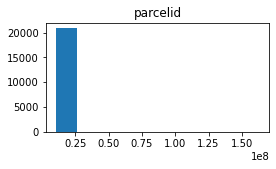

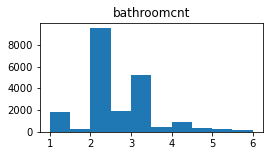

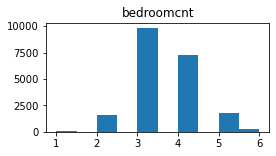

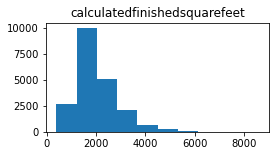

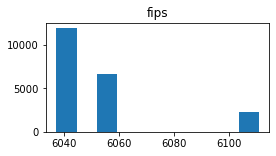

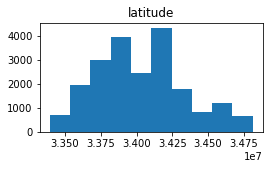

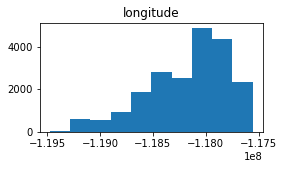

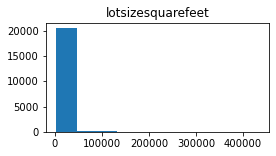

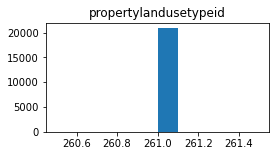

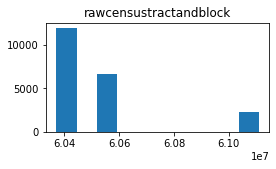

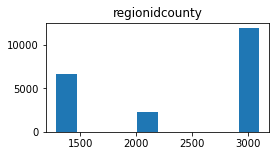

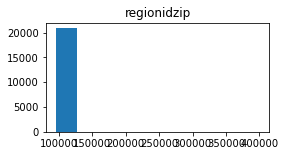

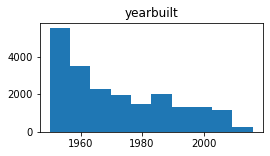

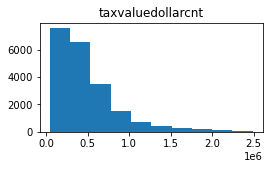

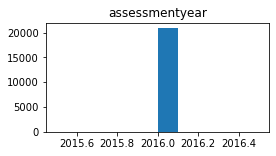

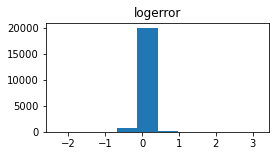

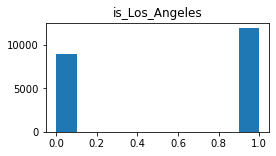

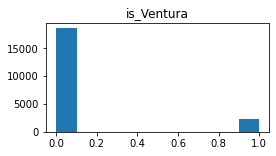

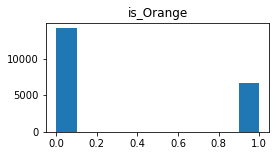

In [21]:
#looking at the change of distribution now for features...
#create all the histograms:
for col in train.columns:
    plt.figure(figsize=(4,2))
    plt.hist(train[col])
    plt.title(col)
    plt.show()

### Conclusion:
- most of the features (ie taxvaluedollar, yearbuilt, bed/bath, & calculatedsqft) are right-skewed. I will use a spearman's correlation test when testing the linear relationships.
- There is more data for Los Angeles county than the other two counties combined.

## Hypothesis Testing: Question One
>### Does logerror differ across county/region of properties?

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

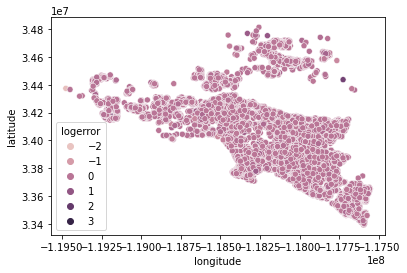

In [22]:
#make a scatter plot for is_outlier
sns.scatterplot(data=train, x='longitude', y='latitude', hue='logerror')

### Taking a look at logerror's size/stats:

In [23]:
train.logerror.describe().T

count    20875.000000
mean         0.018810
std          0.159855
min         -2.331727
25%         -0.021013
50%          0.006770
75%          0.037311
max          3.175688
Name: logerror, dtype: float64

### Take away: The region plot shows that the mean of logerrors is happening all across each of our 3 counties...so I would at least say there isn't 'one' county that is only experiencing these log errors...

I'll use my encoded column 'is_Los_Angeles' in place of fips to t-test as a 2 sample, 2tailed test.

### Step One)

alpha = 0.05

- H_0: There is no difference of variance or mean between county and logerror
- H_a: There is a difference of variance or mean between county and logerror


#### Levene Test to check the variance of is_Los_Angeles (county/fips) and logerror

If p-value > .05, we can say that the variances are not significantly different and set the argument in ttest_ind of equal_var to be True. If p-value < .05, we say the variances are NOT equal and set equal_var to be False.

In [24]:
#Levene Test:
# test the equal variance 
# H0 is that the variances are equal
# our two groups are 1) where train does not equal LA county ==0 and 
# 2) where train does equal LA county == 1

stats.levene(train[train.is_Los_Angeles==0].logerror, 
             train[train.is_Los_Angeles==1].logerror)

LeveneResult(statistic=3.086658331177488, pvalue=0.07895142188751186)

#### Levene score is significantly less than pvalue 0.05, so equal_var is False

### Moving onto a 2-sample, 2-tailed T-test:

In [25]:
stats.ttest_ind(train[train.is_Los_Angeles==0].logerror, 
                train[train.is_Los_Angeles==1].logerror, 
                equal_var=False
               )

Ttest_indResult(statistic=2.7087702122835595, pvalue=0.006760223884334586)

### Conclusion: H_0 is Rejected. There is a difference in mean logerror across county

_____________________________________________________________

## Hypothesis Testing: Question Two 
>### Is there a relationship between yearbuilt and logerror?

### I'll do a Spearman's correlation test to see if there is a relationship

a = 0.05
- H_0: There is no relationship between logerror and yearbuilt 
- Ha: There is a relationship of mean between logerror and yearbuilt


Is there a relationship
between yearbuilt and logerror?


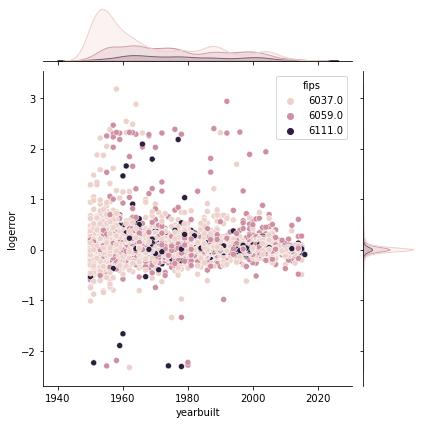

In [26]:
#creating a joinplot to see if any linear relationship (also adding in county)

print("Is there a relationship\nbetween yearbuilt and logerror?")
sns.jointplot(x="yearbuilt", y="logerror", data=train, hue = 'fips')
plt.xlabel("Year built")
plt.ylabel("Logerror")
plt.show()

In [27]:
stats.spearmanr(train.yearbuilt, train.logerror)

SpearmanrResult(correlation=0.03555923012702954, pvalue=2.762334993927697e-07)

### Conclusion: I reject the null hypothesis, as there is a relationship between yearbuilt and logerror

___________________________________________________________

## Hypothesis Testing: Question Three
>### Is there a relationship to logerror and calculated squarefeet?

a = 0.05
- H_0: There is no relationship between calculated sqft and logerror 
- Ha: There is a relationship of mean between calculated sqft and logerror

Is there a relationship
between Sqft and logerror?


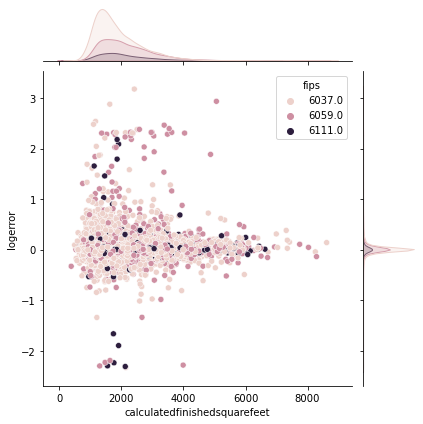

In [28]:
#creating a joinplot to see if any linear relationship (also adding in county)

print("Is there a relationship\nbetween Sqft and logerror?")
sns.jointplot(x="calculatedfinishedsquarefeet", y="logerror", data=train, hue = 'fips')
plt.xlabel("Finished Squarefeet")
plt.ylabel("Logerror")
plt.show()

>### Spearman's correlation test to see if there is a relationship between calculated finished sqft and logerror

In [29]:
stats.spearmanr(train.calculatedfinishedsquarefeet, train.logerror)

SpearmanrResult(correlation=0.08537723537999817, pvalue=4.449157659401028e-35)

### Conclusion: There is a relationship found between logerror and Finished Squarefeet. I reject the null hypothesis.

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

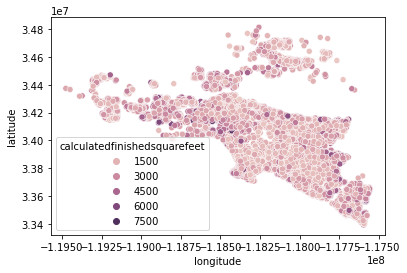

In [30]:
###Note: I wonder if I put in calculated sqft what the lat/long. map would look like:
#make a scatter plot for is_outlier
sns.scatterplot(data=train, x='longitude', y='latitude', hue='calculatedfinishedsquarefeet')

### TAKEAWAYS: 
This simple scatterplot isn't showing very much, however I think that once I find some clusters within the clustering section and label those, I'll try bringing these labeled clusters back to the lat/long. chart...

## (Added Hypothesis Test after looking at cluster_features below)
>### Is there a relationship to logerror and lotsize?

a = 0.05
- H_0: There is no relationship between lot size and logerror 
- Ha: There is a relationship of mean between lot size and logerror

(array([2.0494e+04, 2.2600e+02, 8.9000e+01, 2.1000e+01, 1.3000e+01,
        1.5000e+01, 7.0000e+00, 5.0000e+00, 3.0000e+00, 2.0000e+00]),
 array([  2500. ,  45704.9,  88909.8, 132114.7, 175319.6, 218524.5,
        261729.4, 304934.3, 348139.2, 391344.1, 434549. ]),
 <BarContainer object of 10 artists>)

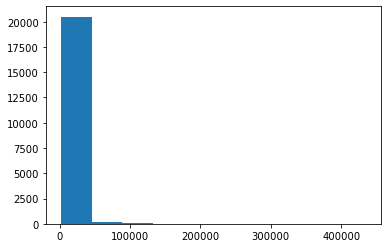

In [31]:
#checking the shape of lotsize:
plt.hist(train.lotsizesquarefeet)

In [32]:
#right-skewed so using Spearman's corr. test
stats.spearmanr(train.lotsizesquarefeet, train.logerror)

SpearmanrResult(correlation=0.010443677589933325, pvalue=0.1313313772144522)

### Conclusion: I accept the null hypothesis, in that there is no relationship between lotsize and logerror

_____________________________________________________________________________________________________________

## Scaling Data
>  I am creating a scaled version of the data (while keeping unscaled), to use for clustering the features I found within hypothesis testing.

In [33]:
#looking at the columns I want to use later to look at via clustering
train.columns

Index(['parcelid', 'bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet',
       'fips', 'latitude', 'longitude', 'lotsizesquarefeet',
       'propertylandusetypeid', 'rawcensustractandblock', 'regionidcounty',
       'regionidzip', 'yearbuilt', 'taxvaluedollarcnt', 'assessmentyear',
       'logerror', 'is_Los_Angeles', 'is_Ventura', 'is_Orange'],
      dtype='object')

In [34]:
#creating a function that scales these columns 

def scale(train, validate, test):
    columns_to_scale = ['calculatedfinishedsquarefeet','lotsizesquarefeet','latitude','longitude','taxvaluedollarcnt','yearbuilt']
    train_scaled = train.copy()
    validate_scaled = validate.copy()
    test_scaled = test.copy()

    scaler = MinMaxScaler()
    scaler.fit(train[columns_to_scale])

    train_scaled[columns_to_scale] = scaler.transform(train[columns_to_scale])
    validate_scaled[columns_to_scale] = scaler.transform(validate[columns_to_scale])
    test_scaled[columns_to_scale] = scaler.transform(test[columns_to_scale])

    return scaler, train_scaled, validate_scaled, test_scaled

In [35]:
#calling in the function and data

scaler, train_scaled, validate_scaled, test_scaled = wrangle.scale(train, validate, test)
train_scaled

,parcelid,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,propertylandusetypeid,rawcensustractandblock,regionidcounty,regionidzip,yearbuilt,taxvaluedollarcnt,assessmentyear,logerror,is_Los_Angeles,is_Ventura,is_Orange
34222,11533536,1.0,2.0,0.058774,6037.0,0.417740,0.547404,0.005791,261.0,6.037275e+07,3101.0,96047.0,0.000000,0.303484,2016.0,0.063660,1,0,0
21551,11058331,2.0,3.0,0.104797,6037.0,0.617615,0.511685,0.012256,261.0,6.037111e+07,3101.0,96370.0,0.045455,0.053134,2016.0,0.059323,1,0,0
39107,14003091,2.0,4.0,0.094353,6059.0,0.282214,0.775957,0.011226,261.0,6.059088e+07,1286.0,97023.0,0.060606,0.093876,2016.0,0.184348,0,0,1
9029,14208016,2.0,3.0,0.134912,6059.0,0.329871,0.888447,0.008101,261.0,6.059022e+07,1286.0,97027.0,0.378788,0.195662,2016.0,-0.004648,0,0,1
37302,11677170,2.0,3.0,0.148148,6037.0,0.486774,0.455126,0.010163,261.0,6.037800e+07,3101.0,96126.0,0.636364,0.204958,2016.0,0.068618,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51645,11145982,3.0,4.0,0.245780,6037.0,0.705832,0.489788,0.011746,261.0,6.037920e+07,3101.0,96373.0,0.757576,0.230738,2016.0,0.027080,1,0,0
26973,12685721,2.0,3.0,0.167335,6037.0,0.284459,0.577186,0.017804,261.0,6.037670e+07,3101.0,96121.0,0.030303,0.039255,2016.0,-0.171849,1,0,0
26978,11203451,2.0,3.0,0.143291,6037.0,0.830435,0.726030,0.010559,261.0,6.037911e+07,3101.0,97328.0,0.227273,0.060525,2016.0,0.050356,1,0,0
6444,13060661,3.0,5.0,0.221494,6037.0,0.449503,0.872397,0.011029,261.0,6.037403e+07,3101.0,96505.0,0.227273,0.164441,2016.0,0.027504,1,0,0


________________________________________________________________________________________________________

# Clustering the Features:

>### Creating labels for clusters to add to my train dataset to hypothesis test and model with:

### This first cluster (named cluster_features) I'll create a label that adds in all of the features I tested and am considering when it comes to their relationship to finding the mean of logerror.

In [36]:
#naming features as X for clustering
X = train_scaled[['calculatedfinishedsquarefeet', 'yearbuilt', 'lotsizesquarefeet','is_Los_Angeles','is_Ventura','is_Orange']]

In [37]:
#creating the KMeans model, fitting the model then predicting with it
kmeans = KMeans(n_clusters=3)
kmeans.fit(X)

kmeans.predict(X)


array([0, 0, 1, ..., 0, 0, 0], dtype=int32)

In [38]:
#storing this predicted cluster of data into original dataframe
train_scaled['cluster_features'] = kmeans.predict(X)

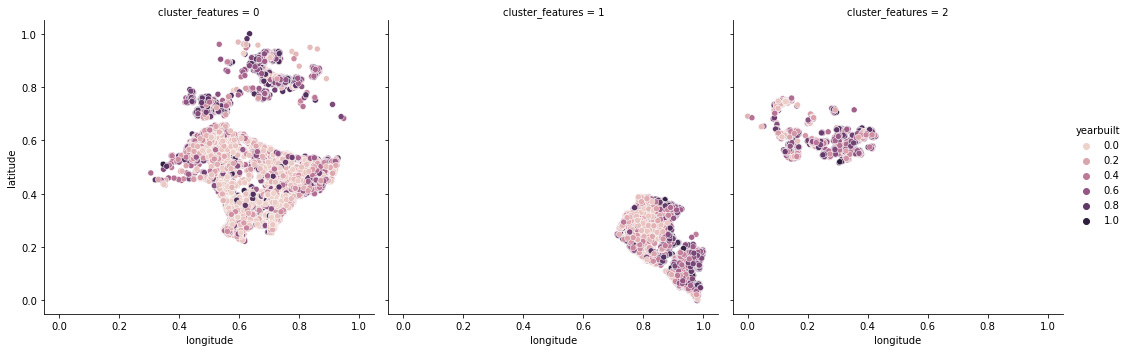

In [39]:
#Now Visualizing the clusters predicted, using 'cluster' as hue to show the 3 clusters
sns.relplot(data=train_scaled, x='longitude', y='latitude', col= 'cluster_features', hue ='yearbuilt')

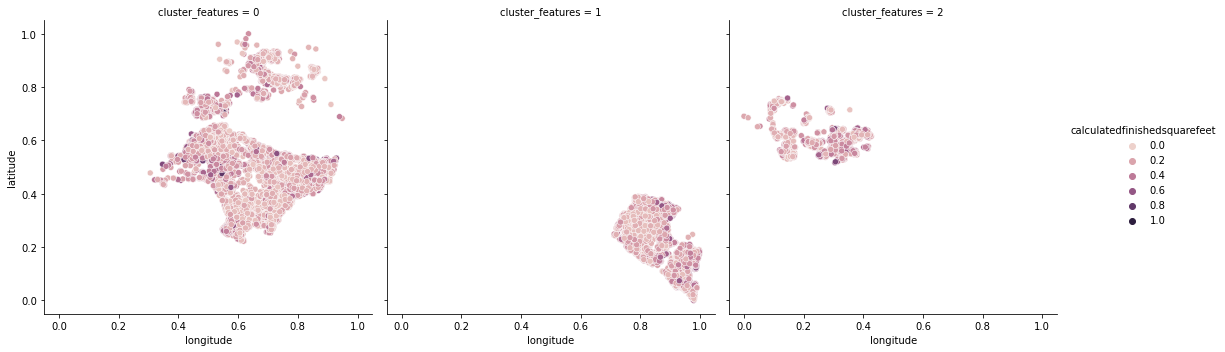

In [40]:
#Now Visualizing the clusters predicted, using 'cluster' as hue to show the 3 clusters
sns.relplot(data=train_scaled, x='longitude', y='latitude', col= 'cluster_features', hue ='calculatedfinishedsquarefeet')

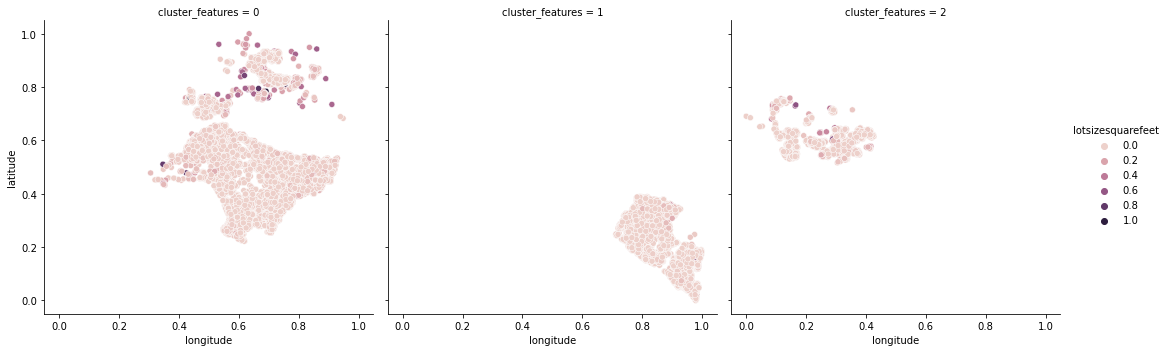

In [41]:
#Now Visualizing the clusters predicted, using 'cluster' as hue to show the 3 clusters
sns.relplot(data=train_scaled, x='longitude', y='latitude', col= 'cluster_features', hue ='lotsizesquarefeet')

#### TAKEAWAY: 
I think adding all of these features in the cluster add a lot of noise. I do however see when adding 'hue' there are patterns of yearsbuilt to certain county regions as well as calculated square feet.

The relationship between calculated squarefeet and yearbuilt makes sense as through the years squarefootage of housing I can imagine got larger. 

When clustering with the lotsize, there isn't a similar looking pattern happening per county, making me think that this is not a strong predictor of logerror. After adding in a Spearman's hypothesis test above to check on lotsize vs logerror, I can see that this is an accurate prediction--there is no real relationship to lotsize and logerror.

> ### Adding solo clusters to dataset and creating, fitting and apply to models:
> ## Property Squarefeet and Years Built-Cluster

In [42]:
#naming features as X for clustering
X = train_scaled[['calculatedfinishedsquarefeet', 'yearbuilt']]

In [43]:
#creating the KMeans model, fitting the model then predicting with it
kmeans = KMeans(n_clusters=3)
kmeans.fit(X)

kmeans.predict(X)

#storing this predicted cluster of data into original dataframe
train_scaled['cluster_prop_age_size'] = kmeans.predict(X)

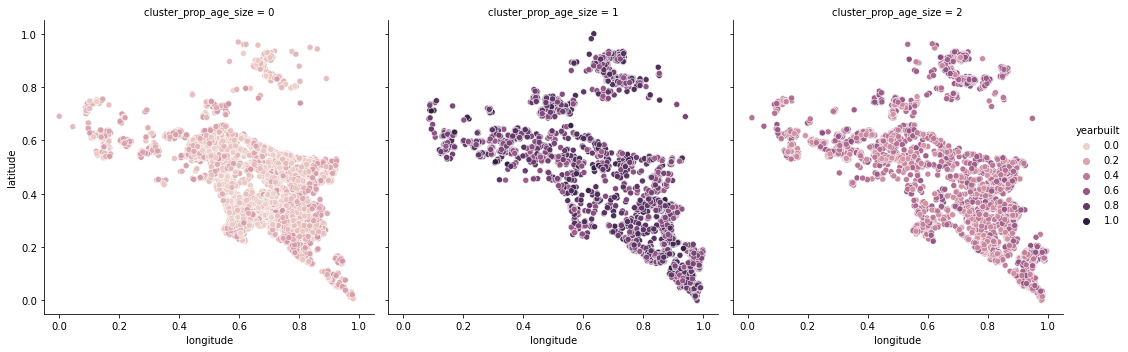

In [44]:
#Now Visualizing the clusters predicted, using 'cluster' as hue to show the 3 clusters
sns.relplot(data=train_scaled, x='longitude', y='latitude', col= 'cluster_prop_age_size', hue ='yearbuilt')

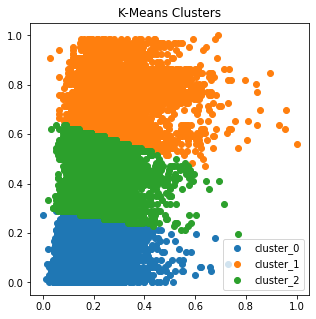

In [45]:
#visualizing the clusters
plt.figure(figsize=(5, 5))

for cluster_n in train_scaled.cluster_prop_age_size.sort_values().unique():
    plt.scatter(train_scaled[train_scaled.cluster_prop_age_size == cluster_n].calculatedfinishedsquarefeet, train_scaled[train_scaled.cluster_prop_age_size == cluster_n].yearbuilt, label=f'cluster_{cluster_n}')

plt.legend()
plt.title("K-Means Clusters")
plt.show()

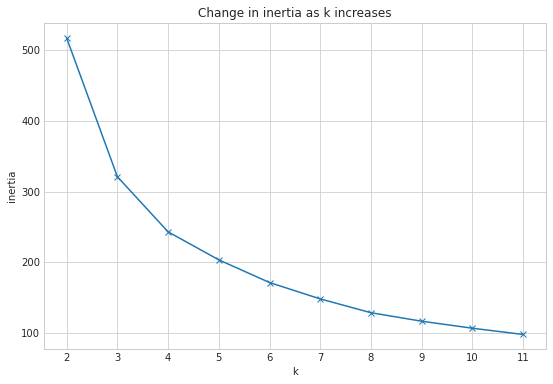

In [46]:
#using the elbow method to determine if k=3 is best fit:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

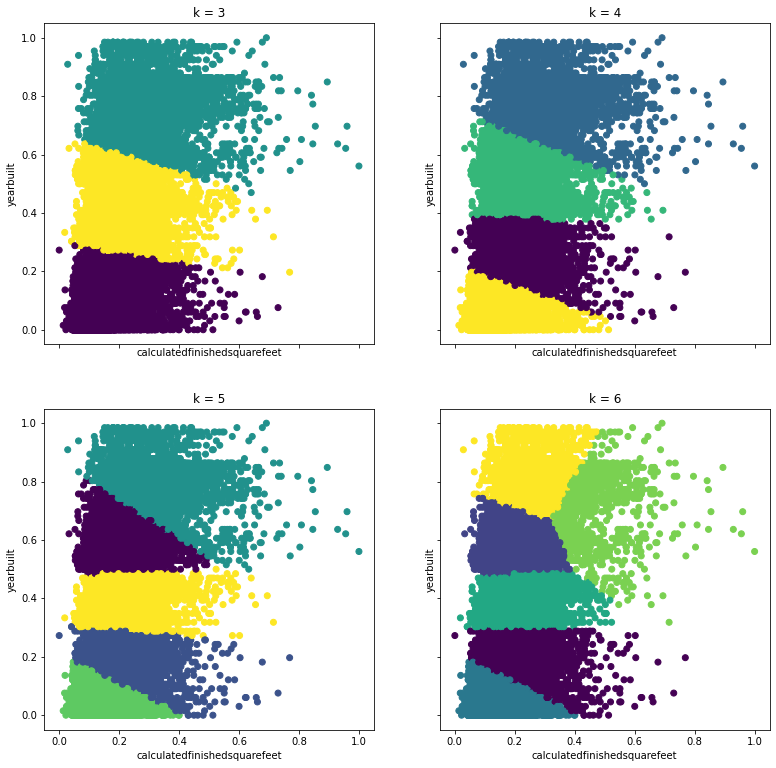

In [47]:
#yes, 3 seems right so now let's plot:
fig, axs = plt.subplots(2, 2, figsize=(13, 13), sharex=True, sharey=True)

for ax, k in zip(axs.ravel(), range(3, 7)):
    clusters = KMeans(k).fit(X).predict(X)
    ax.scatter(X.calculatedfinishedsquarefeet, X.yearbuilt, c=clusters)
    ax.set(title='k = {}'.format(k), xlabel='calculatedfinishedsquarefeet', ylabel='yearbuilt')

### Conclusion:
I would actually go with  k = 3 as the clusters are not only capturing a good grouping of section of years and the movement happening in terms of calculated finished square feet but it also has good indicator that it could be helpful to me if I bins years and use them as classifications rather than continous.

__________________________________________________________________________________________________________________

## Creating a Cluster for just is_Los_Angeles 

In [48]:
#Is_Los_Angeles, Sqft, Bathroomcnt
#naming features as X for clustering
X = train_scaled[['calculatedfinishedsquarefeet', 'yearbuilt','is_Los_Angeles','bathroomcnt','taxvaluedollarcnt','latitude','longitude']]

In [49]:
#creating the KMeans model, fitting the model then predicting with it
kmeans = KMeans(n_clusters=3)
kmeans.fit(X)

kmeans.predict(X)

#storing this predicted cluster of data into original dataframe
train_scaled['cluster_la'] = kmeans.predict(X)

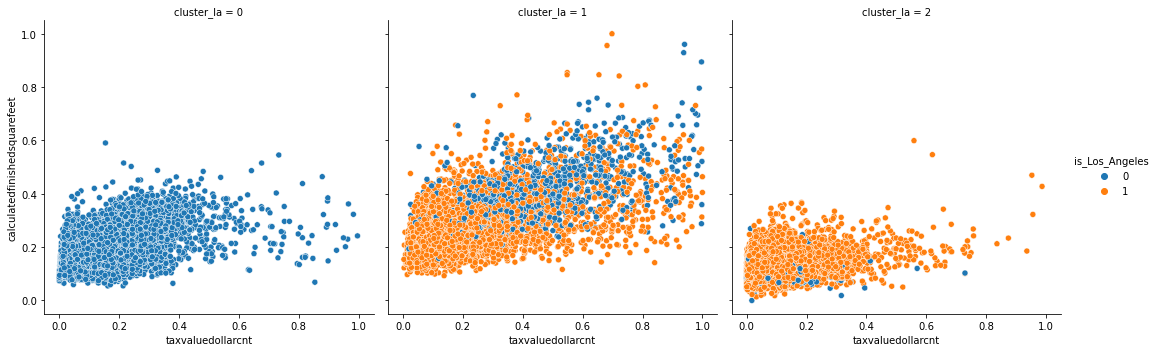

In [50]:
#Now Visualizing the clusters predicted, using property value as hue to show the 3 clusters
sns.relplot(data=train_scaled, x='taxvaluedollarcnt', y='calculatedfinishedsquarefeet', col='cluster_la', hue ='is_Los_Angeles')

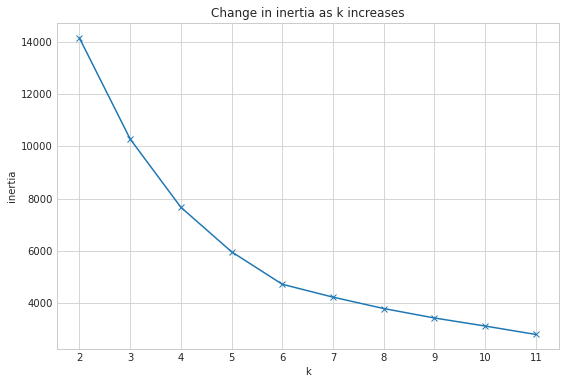

In [51]:
#seeing if k is right size for this cluster set:
#using the elbow method to determine if k=3 is best fit:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

### Takeaway: 
I don't think this cluster set is very helpful in targeting differences of mean and property predictors, so in turn I don't think that it would be worthwhile in putting in towards looking at logerror. 

>## Cluster for property size and value and location:

In [52]:
#Is_Los_Angeles, Sqft, Bathroomcnt
#naming features as X for clustering
X = train_scaled[['calculatedfinishedsquarefeet', 'taxvaluedollarcnt','latitude','longitude']]

In [53]:
#creating the KMeans model, fitting the model then predicting with it
kmeans = KMeans(n_clusters=3)
kmeans.fit(X)

kmeans.predict(X)

#storing this predicted cluster of data into original dataframe
train_scaled['cluster_value'] = kmeans.predict(X)

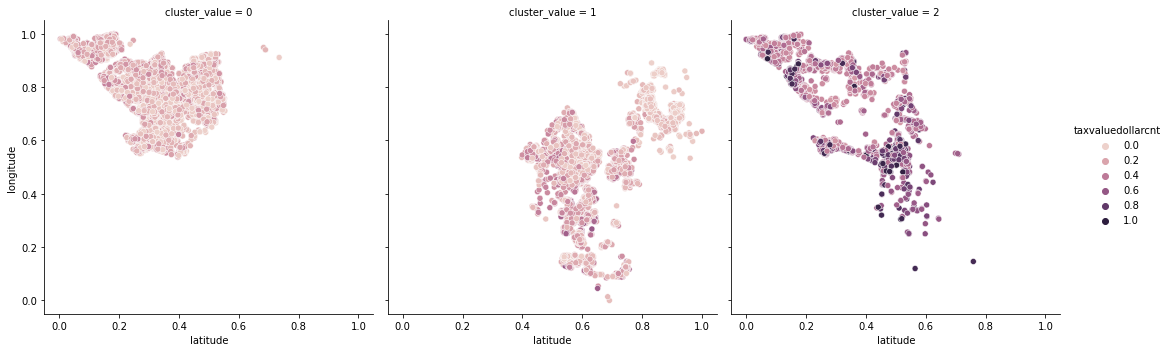

In [54]:
#Now Visualizing the clusters predicted, using property value as hue to show the 3 clusters
sns.relplot(data=train_scaled, x='latitude', y='longitude', col='cluster_value', hue='taxvaluedollarcnt')

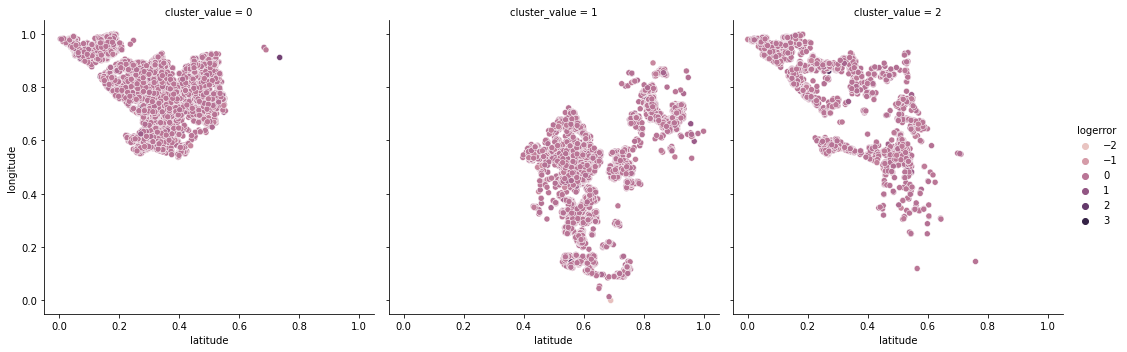

In [55]:
#In relation to what this cluster looks like as hued 'logerror'
sns.relplot(data=train_scaled, x='latitude', y='longitude', col='cluster_value', hue='logerror')

### Takeaway:

I was thinking that possibly the higher the taxvaluedollar count with the cluster_value groupings compared to logerror, would return a pattern in the highest logerror results--however this is not the case. 

I may look into using logerror to create my outliers in the future.

________________________________________________________________________________________________________

# Statistical Testing my Cluster models to Logerror:

I'll be using my best clustering models ('cluster_features' & 'cluster_prop_age_size') to test against logerror to see if there is a relationship connected between the two.

Having looked at the distribution shapes of both logerror AND the new cluster-features column, they both have a 'normalish' shape so I will test using a One-Sample T-test to compare means of each.


(array([11946.,     0.,     0.,     0.,     0.,  6694.,     0.,     0.,
            0.,  2235.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

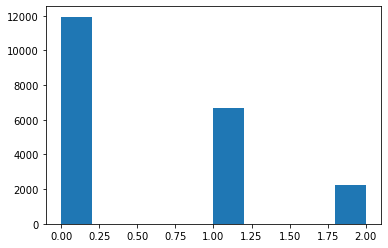

In [56]:
#checking the shape of lotsize:
plt.hist(train_scaled.cluster_features)

(array([10619.,     0.,     0.,     0.,     0.,  4260.,     0.,     0.,
            0.,  5996.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

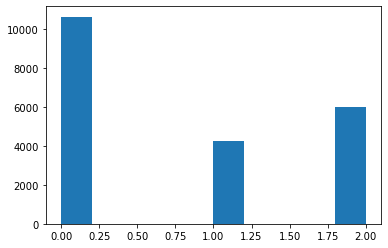

In [57]:
#checking the shape of lotsize:
plt.hist(train_scaled.cluster_prop_age_size)

(array([9.0000e+00, 3.0000e+00, 1.4000e+01, 6.8100e+02, 1.9912e+04,
        1.8100e+02, 2.6000e+01, 1.8000e+01, 2.8000e+01, 3.0000e+00]),
 array([-2.33172653, -1.78098508, -1.23024363, -0.67950218, -0.12876073,
         0.42198072,  0.97272217,  1.52346362,  2.07420507,  2.62494652,
         3.17568797]),
 <BarContainer object of 10 artists>)

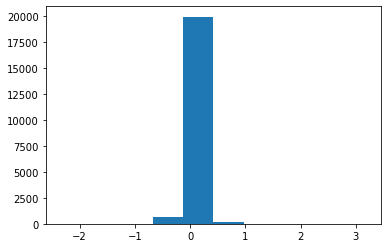

In [58]:
#checking the shape of lotsize:
plt.hist(train_scaled.logerror)

>## Test One: Does cluster_features (overall features chosen) relate to logerror?

- a = 0.05
- H_0: There is no difference of mean between logerror and cluster-features
- Ha: There is a difference of mean between logerror and cluster-features

In [59]:
alpha = .05

sample_mean = train_scaled.cluster_features
logerror_mean = train_scaled.logerror.mean()


t, p = stats.ttest_1samp(sample_mean, logerror_mean)

print(t, p/2, alpha)


109.57030414620316 0.0 0.05


In [60]:
if p/2 > alpha:
    print("We fail to reject null Hypothesis")
elif t < 0:
    print("We fail to reject null Hypothesis")
else:
    print("We reject null Hypothesis")


We reject null Hypothesis


>## Test Two: Does cluster_prop_age_size (only property age & sqft) relate to logerror?

- a = 0.05
- H_0: There is no difference of mean between logerror and property age/size
- Ha: There is a difference of mean between logerror and property age/size

In [61]:
alpha = .05

sample_mean = train_scaled.cluster_prop_age_size
logerror_mean = train_scaled.logerror.mean()


t, p = stats.ttest_1samp(sample_mean, logerror_mean)

print(t, p/2, alpha)

127.00918737084925 0.0 0.05


In [62]:
if p/2 > alpha:
    print("We fail to reject null Hypothesis")
elif t < 0:
    print("We fail to reject null Hypothesis")
else:
    print("We reject null Hypothesis")

We reject null Hypothesis


# Modeling:

I'll be utilizing the Regression Models: OLS | LassoLARS | TweedieRegressor | Polynomial Regression

>### Creating baseline of the current predictor of median margin of error (aka logerror)

In [63]:
#Lets take a look at simple model of features based on the cluster_features model made and compare if against the logerror
X_train = train[['calculatedfinishedsquarefeet', 'yearbuilt', 'lotsizesquarefeet','is_Los_Angeles','is_Ventura','is_Orange']]
y_train = train[['logerror']]
y_train['y_baseline'] = train['logerror'].median()

X_validate = validate[['calculatedfinishedsquarefeet', 'yearbuilt', 'lotsizesquarefeet','is_Los_Angeles','is_Ventura','is_Orange']]
y_validate = validate[['logerror']]
y_validate['y_baseline'] = validate['logerror'].median()

# predictor/independent features split into train, test, validate
X_train = train.drop(columns = ['logerror'],axis=1)
X_validate = validate.drop(columns = ['logerror'],axis=1)
X_test = test.drop(columns = ['logerror'],axis=1)

# target variables split into train, test, validate
y_train = train.logerror
y_validate = validate.logerror
y_test = test.logerror

In [98]:
# We need y_train and y_validate to be dataframes to append the new columns with predicted values. 
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

# 1. Predict logerror_pred_mean
logerror_pred_mean = y_train['logerror'].mean()
y_train['logerror_pred_mean'] = logerror_pred_mean
y_validate['logerror_pred_mean'] = logerror_pred_mean

# 2. compute logerror_pred_median
logerror_pred_median = y_train['logerror'].median()
y_train['logerror_pred_median'] = logerror_pred_median
y_validate['logerror_pred_median'] = logerror_pred_median

# 3. RMSE of logerror_pred_mean
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_mean)**(1/2)
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_mean)**(1/2)

print("RMSE using Mean\nTrain/In-Sample: ", (rmse_train), 
      "\nValidate/Out-of-Sample: ", (rmse_validate))

# 4. RMSE of logerror_pred_median
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_median)**(1/2)
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_median)**(1/2)

print("RMSE using Median\nTrain/In-Sample: ", (rmse_train), 
      "\nValidate/Out-of-Sample: ", (rmse_validate))


RMSE using Mean
Train/In-Sample:  0.1598506946389631 
Validate/Out-of-Sample:  0.1704170241810743
RMSE using Median
Train/In-Sample:  0.1603035121371792 
Validate/Out-of-Sample:  0.17074853002637033


In [88]:
#looking at baseline predicted mean for later graphing
y_train

,logerror,logerror_pred_mean,logerror_pred_median
34222,0.063660,0.01881,0.00677
21551,0.059323,0.01881,0.00677
39107,0.184348,0.01881,0.00677
9029,-0.004648,0.01881,0.00677
37302,0.068618,0.01881,0.00677
...,...,...,...
51645,0.027080,0.01881,0.00677
26973,-0.171849,0.01881,0.00677
26978,0.050356,0.01881,0.00677
6444,0.027504,0.01881,0.00677


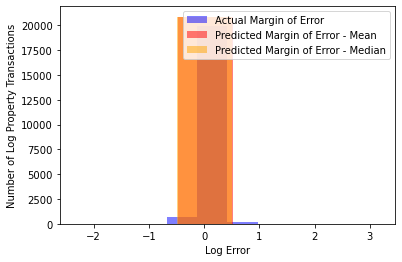

In [65]:
# Using histogram to plot the actual vs predicted means

plt.hist(y_train.logerror, color='blue', alpha=.5, label="Actual Margin of Error")
plt.hist(y_train.logerror_pred_mean, bins=1, color='red', alpha=.5, rwidth=100, label="Predicted Margin of Error - Mean")
plt.hist(y_train.logerror_pred_median, bins=1, color='orange', alpha=.5, rwidth=100, label="Predicted Margin of Error - Median")
plt.xlabel("Log Error")
plt.ylabel("Number of Log Property Transactions")
plt.legend()
plt.show()


> ### OLS Model: 

In [66]:
#Lets take a look at simple model of features based on the cluster_features model made and compare if against the logerror
X_train1 = train[['calculatedfinishedsquarefeet', 'yearbuilt', 'lotsizesquarefeet','is_Los_Angeles','is_Ventura','is_Orange']]
y_train1 = train[['logerror']]
y_train1['y_baseline'] = train['logerror'].median()

X_validate1 = validate[['calculatedfinishedsquarefeet', 'yearbuilt', 'lotsizesquarefeet','is_Los_Angeles','is_Ventura','is_Orange']]
y_validate1 = validate[['logerror']]
y_validate1['y_baseline'] = validate['logerror'].median()

# predictor/independent features split into train, test, validate
X_train1 = train.drop(columns = ['logerror'],axis=1)
X_validate1 = validate.drop(columns = ['logerror'],axis=1)
X_test1 = test.drop(columns = ['logerror'],axis=1)

# target variables split into train, test, validate
y_train1 = train.logerror
y_validate1 = validate.logerror
y_test1 = test.logerror

y_train1 = pd.DataFrame(y_train1)
y_validate1 = pd.DataFrame(y_validate1)

In [67]:
# create the model object
lm = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm.fit(X_train1, y_train1.logerror)

# predict train
y_train1['logerror_pred_lm'] = lm.predict(X_train1)

# evaluate: rmse
rmse_train = mean_squared_error(y_train1.logerror, y_train1.logerror_pred_lm)**(1/2)

# predict validate
y_validate1['logerror_pred_lm'] = lm.predict(X_validate1)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate1.logerror, y_validate1.logerror_pred_lm)**(1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)


RMSE for OLS using LinearRegression
Training/In-Sample:  0.15960634399546783 
Validation/Out-of-Sample:  0.17059294701736424


### Takeaway: Not great. Very close to baseline.

________________________________________________________________

## Onto LassoLars Model:
    I need to get a new X_train labeled dataset...

In [68]:
#Lets take a look at simple model of features based on the cluster_features model made and compare if against the logerror
X_train2 = train[['calculatedfinishedsquarefeet', 'yearbuilt', 'lotsizesquarefeet','is_Los_Angeles','is_Ventura','is_Orange']]
y_train2 = train[['logerror']]
y_train2['y_baseline'] = train['logerror'].median()

X_validate2 = validate[['calculatedfinishedsquarefeet', 'yearbuilt', 'lotsizesquarefeet','is_Los_Angeles','is_Ventura','is_Orange']]
y_validate2 = validate[['logerror']]
y_validate2['y_baseline'] = validate['logerror'].median()

# predictor/independent features split into train, test, validate
X_train2 = train.drop(columns = ['logerror'],axis=1)
X_validate2 = validate.drop(columns = ['logerror'],axis=1)
X_test2 = test.drop(columns = ['logerror'],axis=1)

# target variables split into train, test, validate
y_train2 = train.logerror
y_validate2 = validate.logerror
y_test2 = test.logerror

y_train2 = pd.DataFrame(y_train2)
y_validate2 = pd.DataFrame(y_validate2)

In [69]:
# create the model object
lars = LassoLars(alpha=1.0)

# I first fit the model to the training data. I must specify the column in y_train, 
# since it was converted it to a dataframe from a series! 
lars.fit(X_train2, y_train2.logerror)

# predict train
y_train2['logerror_pred_lars'] = lars.predict(X_train2)

# evaluate: rmse
rmse_train = mean_squared_error(y_train2.logerror, y_train2.logerror_pred_lars)**(1/2)

# predict validate
y_validate2['logerror_pred_lars'] = lars.predict(X_validate2)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate2.logerror, y_validate2.logerror_pred_lars)**(1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)


RMSE for Lasso + Lars
Training/In-Sample:  0.1598506946389631 
Validation/Out-of-Sample:  0.1704170241810743


### Takeaway: Not great. Very close to baseline.

______________________________________________________________________________

## TweedieRegressor (GLM) Model:

In [70]:
#Lets take a look at simple model of features based on the cluster_features model made and compare if against the logerror
X_train3 = train[['calculatedfinishedsquarefeet', 'yearbuilt', 'lotsizesquarefeet','is_Los_Angeles','is_Ventura','is_Orange']]
y_train3 = train[['logerror']]
y_train3['y_baseline'] = train['logerror'].median()

X_validate3 = validate[['calculatedfinishedsquarefeet', 'yearbuilt', 'lotsizesquarefeet','is_Los_Angeles','is_Ventura','is_Orange']]
y_validate3 = validate[['logerror']]
y_validate3['y_baseline'] = validate['logerror'].median()

# predictor/independent features split into train, test, validate
X_train3 = train.drop(columns = ['logerror'],axis=1)
X_validate3 = validate.drop(columns = ['logerror'],axis=1)
X_test3 = test.drop(columns = ['logerror'],axis=1)

# target variables split into train, test, validate
y_train3 = train.logerror
y_validate3 = validate.logerror
y_test3 = test.logerror

y_train3 = pd.DataFrame(y_train3)
y_validate3 = pd.DataFrame(y_validate3)

>### Creating the Model:

In [71]:
# create the model object
glm = TweedieRegressor(power=0, alpha=0.1)

# fit the model to the training data. I must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
glm.fit(X_train3, y_train3.logerror)

# predict train
y_train3['logerror_pred_glm'] = glm.predict(X_train3)

# evaluate: rmse
rmse_train = mean_squared_error(y_train3.logerror, y_train3.logerror_pred_glm)**(1/2)

# predict validate
y_validate3['logerror_pred_glm'] = glm.predict(X_validate3)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate3.logerror, y_validate3.logerror_pred_glm)**(1/2)

print("RMSE for GLM using Tweedie, power=0 & alpha=0.1\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)


RMSE for GLM using Tweedie, power=0 & alpha=0.1
Training/In-Sample:  0.15971159052945708 
Validation/Out-of-Sample:  0.1707394112121391


### Takeaway: Realizing most of these will be close since I am looking at the logerror units....

___________________________________________________________________________________

>## Polynomial Regression: (with 2degrees)

In [72]:
#Lets take a look at simple model of features based on the cluster_features model made and compare if against the logerror
X_train4 = train[['calculatedfinishedsquarefeet', 'yearbuilt', 'lotsizesquarefeet','is_Los_Angeles','is_Ventura','is_Orange']]
y_train4 = train[['logerror']]
y_train4['y_baseline'] = train['logerror'].median()

X_validate4 = validate[['calculatedfinishedsquarefeet', 'yearbuilt', 'lotsizesquarefeet','is_Los_Angeles','is_Ventura','is_Orange']]
y_validate4 = validate[['logerror']]
y_validate4['y_baseline'] = validate['logerror'].median()

# predictor/independent features split into train, test, validate
X_train4 = train.drop(columns = ['logerror'],axis=1)
X_validate4 = validate.drop(columns = ['logerror'],axis=1)
X_test4 = test.drop(columns = ['logerror'],axis=1)

# target variables split into train, test, validate
y_train4 = train.logerror
y_validate4 = validate.logerror
y_test4 = test.logerror

y_train4 = pd.DataFrame(y_train4)
y_validate4 = pd.DataFrame(y_validate4)

In [73]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train4)

# transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_validate4)
X_test_degree2 = pf.transform(X_test4)


In [74]:
# create the model object
lm2 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm2.fit(X_train_degree2, y_train4.logerror)

# predict train
y_train4['logerror_pred_lm2'] = lm2.predict(X_train_degree2)

# evaluate: rmse
rmse_train = mean_squared_error(y_train4.logerror, y_train4.logerror_pred_lm2)**(1/2)

# predict validate
y_validate4['logerror_pred_lm2'] = lm2.predict(X_validate_degree2)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate4.logerror, y_validate4.logerror_pred_lm2)**(1/2)

print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)


RMSE for Polynomial Model, degrees=2
Training/In-Sample:  0.15896558204572908 
Validation/Out-of-Sample:  0.9619112897187132


>## Polynomial Regression: (with 3degrees)

In [75]:
#Lets take a look at simple model of features based on the cluster_features model made and compare if against the logerror
X_train5 = train[['calculatedfinishedsquarefeet', 'yearbuilt', 'lotsizesquarefeet','is_Los_Angeles','is_Ventura','is_Orange']]
y_train5 = train[['logerror']]
y_train5['y_baseline'] = train['logerror'].median()

X_validate5 = validate[['calculatedfinishedsquarefeet', 'yearbuilt', 'lotsizesquarefeet','is_Los_Angeles','is_Ventura','is_Orange']]
y_validate5 = validate[['logerror']]
y_validate5['y_baseline'] = validate['logerror'].median()

# predictor/independent features split into train, test, validate
X_train5 = train.drop(columns = ['logerror'],axis=1)
X_validate5 = validate.drop(columns = ['logerror'],axis=1)
X_test5 = test.drop(columns = ['logerror'],axis=1)

# target variables split into train, test, validate
y_train5 = train.logerror
y_validate5 = validate.logerror
y_test5 = test.logerror

y_train5 = pd.DataFrame(y_train5)
y_validate5 = pd.DataFrame(y_validate5)

In [76]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=3)

# fit and transform X_train_scaled
X_train_degree3 = pf.fit_transform(X_train5)

# transform X_validate_scaled & X_test_scaled
X_validate_degree3 = pf.transform(X_validate5)
X_test_degree3 = pf.transform(X_test5)

In [77]:
# create the model object
lm2 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm2.fit(X_train_degree3, y_train5.logerror)

# predict train
y_train5['logerror_pred_lm2'] = lm2.predict(X_train_degree3)

# evaluate: rmse
rmse_train = mean_squared_error(y_train5.logerror, y_train5.logerror_pred_lm2)**(1/2)

# predict validate
y_validate5['logerror_pred_lm2'] = lm2.predict(X_validate_degree3)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate5.logerror, y_validate5.logerror_pred_lm2)**(1/2)

print("RMSE for Polynomial Model, degrees=3\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Polynomial Model, degrees=3
Training/In-Sample:  0.24170428064386643 
Validation/Out-of-Sample:  335.9874401928189


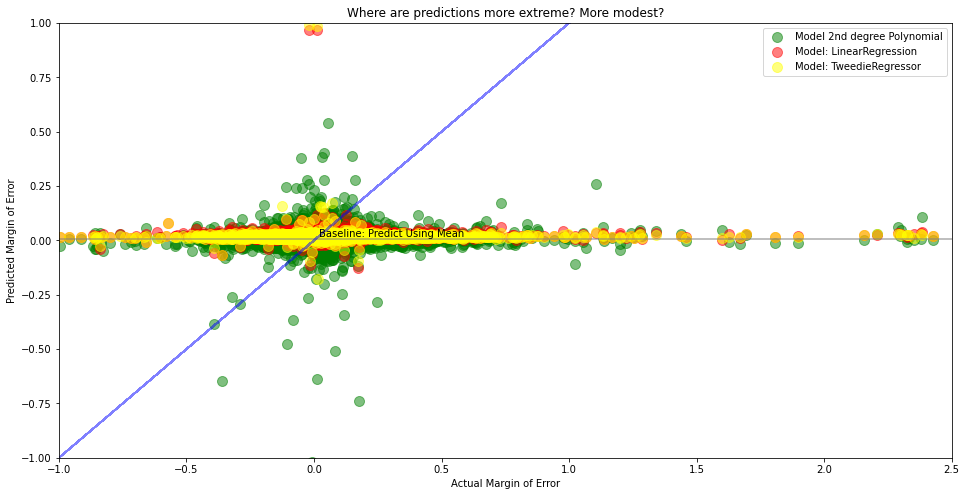

In [96]:
# y_validate.head()
plt.figure(figsize=(16,8))
plt.xlim(-1, 2.5)
plt.ylim(-1, 1)
plt.plot(y_validate.logerror, y_validate.logerror_pred_median, alpha=.5, color="gray", label='_nolegend_')
plt.annotate("Baseline: Predict Using Mean", (0.019, 0.019 ))
plt.plot(y_validate.logerror, y_validate.logerror, alpha=.5, color="blue", label='_nolegend_')
plt.annotate("The Ideal Line: Predicted = Actual", (.5, 3.5), rotation=15.5)


plt.scatter(y_validate4.logerror, y_validate4.logerror_pred_lm2, 
            alpha=.5, color="green", s=100, label="Model 2nd degree Polynomial")
plt.scatter(y_validate1.logerror, y_validate1.logerror_pred_lm, 
            alpha=.5, color="red", s=100, label="Model: LinearRegression")
plt.scatter(y_validate3.logerror, y_validate3.logerror_pred_glm, 
            alpha=.5, color="yellow", s=100, label="Model: TweedieRegressor")



plt.legend()
plt.xlabel("Actual Margin of Error")
plt.ylabel("Predicted Margin of Error")
plt.title("Where are predictions more extreme? More modest?")
# plt.annotate("The polynomial model appears to overreact to noise", (2.0, -10))
# plt.annotate("The OLS model (LinearRegression)\n appears to be most consistent", (15.5, 3))
plt.show()


In [99]:
#next step: creating a table the shows the results of each RMSE to baseline (of mean/median)